In [3]:
from __future__ import print_function
import GPy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import createLOB
import  gpyNARX

ModuleNotFoundError: No module named 'createLOB'

In [4]:
nSamples = 140
X1 = np.random.rand(nSamples, 1)*8*np.pi
X1.sort(0)
Y1 = np.sin(X1) + np.random.randn(*X1.shape)*0.002

U1 = np.sin(X1) + np.random.randn(*X1.shape)*0.02
U1 = Y1**2-2*Y1+5+np.random.randn(*Y1.shape)*0.005

In [5]:
data = pd.DataFrame( np.concatenate( [X1, Y1, U1], axis= 1), columns =['X', 'Y', 'U'])

In [10]:
timeWindow = 10
data = data.merge(pd.concat([data.shift(lag).rename(columns = lambda c: 'lagged_{}_{}'.format(c , lag) ) for lag in range(1, timeWindow+1 )],axis=1), right_index=True, left_index=True, how='left')
data = data.dropna()

In [11]:
data.head(10)

,X,Y,U,lagged_X_1_x,lagged_Y_1_x,lagged_U_1_x,lagged_X_2_x,lagged_Y_2_x,lagged_U_2_x,lagged_X_3_x,...,lagged_lagged_U_7_10,lagged_lagged_X_8_10,lagged_lagged_Y_8_10,lagged_lagged_U_8_10,lagged_lagged_X_9_10,lagged_lagged_Y_9_10,lagged_lagged_U_9_10,lagged_lagged_X_10_10,lagged_lagged_Y_10_10,lagged_lagged_U_10_10
20,4.518384,-0.982372,7.924162,4.438944,-0.961975,7.850869,4.419521,-0.958657,7.835152,4.388462,...,4.000787,1.140635,0.909016,4.009882,0.887217,0.773854,4.056071,0.867644,0.764074,4.062865
21,4.683396,-0.998168,7.995932,4.518384,-0.982372,7.924162,4.438944,-0.961975,7.850869,4.419521,...,4.003257,1.565597,1.000983,4.000787,1.140635,0.909016,4.009882,0.887217,0.773854,4.056071
22,4.956968,-0.972133,7.893998,4.683396,-0.998168,7.995932,4.518384,-0.982372,7.924162,4.438944,...,4.000954,1.854877,0.960456,4.003257,1.565597,1.000983,4.000787,1.140635,0.909016,4.009882
23,5.043534,-0.947501,7.793163,4.956968,-0.972133,7.893998,4.683396,-0.998168,7.995932,4.518384,...,4.016861,1.921590,0.939688,4.000954,1.854877,0.960456,4.003257,1.565597,1.000983,4.000787
24,5.052655,-0.947620,7.797291,5.043534,-0.947501,7.793163,4.956968,-0.972133,7.893998,4.683396,...,4.072565,2.109421,0.861045,4.016861,1.921590,0.939688,4.000954,1.854877,0.960456,4.003257
25,5.055185,-0.938944,7.766047,5.052655,-0.947620,7.797291,5.043534,-0.947501,7.793163,4.956968,...,4.360132,2.315794,0.733621,4.072565,2.109421,0.861045,4.016861,1.921590,0.939688,4.000954
26,5.175291,-0.898788,7.608002,5.055185,-0.938944,7.766047,5.052655,-0.947620,7.797291,5.043534,...,4.514972,2.733749,0.398704,4.360132,2.315794,0.733621,4.072565,2.109421,0.861045,4.016861
27,5.325072,-0.817867,7.301921,5.175291,-0.898788,7.608002,5.055185,-0.938944,7.766047,5.052655,...,5.021888,2.850405,0.287188,4.514972,2.733749,0.398704,4.360132,2.315794,0.733621,4.072565
28,5.329895,-0.816651,7.297017,5.325072,-0.817867,7.301921,5.175291,-0.898788,7.608002,5.055185,...,5.028312,3.154513,-0.011515,5.021888,2.850405,0.287188,4.514972,2.733749,0.398704,4.360132
29,5.377676,-0.786242,7.193179,5.329895,-0.816651,7.297017,5.325072,-0.817867,7.301921,5.175291,...,5.161787,3.156699,-0.013619,5.028312,3.154513,-0.011515,5.021888,2.850405,0.287188,4.514972


In [12]:
laggedYColumns = [c for c in data.columns if 'lagged_Y' in c]
laggedUColumns = [c for c in data.columns if 'lagged_U' in c]
inputColumns = laggedYColumns + laggedUColumns
outputColumn ='Y'


In [13]:
dataSize= data.shape[0]
trainDataSize = 50
testDataSize = dataSize - trainDataSize

In [17]:
trainData = data.iloc[:trainDataSize]
testData = data.iloc[:testDataSize]

In [21]:
trainData[inputColumns].head(4)

,lagged_Y_1_x,lagged_Y_2_x,lagged_Y_3_x,lagged_Y_4_x,lagged_Y_5_x,lagged_Y_6_x,lagged_Y_7_x,lagged_Y_8_x,lagged_Y_9_x,lagged_Y_10_x,...,lagged_lagged_U_1_10,lagged_lagged_U_2_10,lagged_lagged_U_3_10,lagged_lagged_U_4_10,lagged_lagged_U_5_10,lagged_lagged_U_6_10,lagged_lagged_U_7_10,lagged_lagged_U_8_10,lagged_lagged_U_9_10,lagged_lagged_U_10_10
20,-0.961975,-0.958657,-0.947503,-0.853557,-0.733236,-0.717685,-0.619577,-0.075734,-0.013619,-0.011515,...,4.514972,4.360132,4.072565,4.016861,4.000954,4.003257,4.000787,4.009882,4.056071,4.062865
21,-0.982372,-0.961975,-0.958657,-0.947503,-0.853557,-0.733236,-0.717685,-0.619577,-0.075734,-0.013619,...,5.021888,4.514972,4.360132,4.072565,4.016861,4.000954,4.003257,4.000787,4.009882,4.056071
22,-0.998168,-0.982372,-0.961975,-0.958657,-0.947503,-0.853557,-0.733236,-0.717685,-0.619577,-0.075734,...,5.028312,5.021888,4.514972,4.360132,4.072565,4.016861,4.000954,4.003257,4.000787,4.009882
23,-0.972133,-0.998168,-0.982372,-0.961975,-0.958657,-0.947503,-0.853557,-0.733236,-0.717685,-0.619577,...,5.161787,5.028312,5.021888,4.514972,4.360132,4.072565,4.016861,4.000954,4.003257,4.000787


In [19]:

# Train regression model
num_inducing = 40
m = GPy.models.SparseGPRegression(trainData[inputColumns].values, trainData[outputColumn].values, num_inducing = num_inducing)
# m.optimize('bfgs', max_iters=1000, messages=True)
# print(m)

AssertionError: 

NameError: name 'transformTimeSeriesToSeq' is not defined

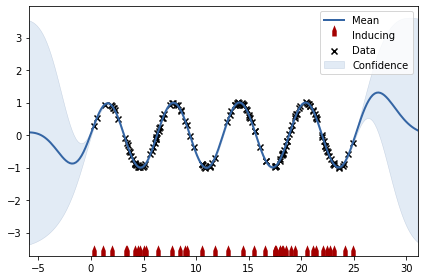

In [22]:
# Create toy data
N1 = 140
X1 = np.random.rand(N1, 1) * 8*np.pi
X1.sort(0)
Y1 = np.sin(X1) + np.random.randn(*X1.shape) * 0.02
#U1 = X1%(2*np.pi)

# Train a standard model
m1 = GPy.models.SparseGPRegression(X1,Y1, num_inducing = num_inducing)
m1.optimize('bfgs', max_iters=100)
m1.plot()

# Create transformed data (autoregressive dataset)
ws=10 # Windowsize
xx,yy = transformTimeSeriesToSeq(Y1, ws)

#uu,tmp = transformTimeSeriesToSeq(U1, ws)
# Test the above: np.sin(uu) - xx

#uu = yy**2 -2*yy + 5 + np.random.randn(*yy.shape) * 0.005
U1 = Y1**2 -2*Y1 + 5 + np.random.randn(*Y1.shape) * 0.005
uu,tmp = transformTimeSeriesToSeq(U1, ws)

Xtr = xx[0:50,:]
Xts = xx[50:,:]
Ytr = yy[0:50,:]
Yts = yy[50:,:]
Utr = uu[0:50,:]
Uts = uu[50:,:]


# Train regression model
m = GPy.models.SparseGPRegression(np.hstack((Xtr,Utr)),Ytr, num_inducing = num_inducing)
m.optimize('bfgs', max_iters=1000, messages=True)
print(m)

# Initial window to kick-off free simulation
x_start = Xts[0,:][:,None].T